In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch_truncnorm.TruncatedNormal import TruncatedNormal

from function_collection import *

from functools import partial

# mdmm for constrained optimization
import mdmm

# tensorboard
from torch.utils.tensorboard import SummaryWriter

In [3]:
# create folder to save results
import os
if not os.path.exists('results_1d_beam'):
    os.makedirs('results_1d_beam')


We consider a 1D beam of length 3L, with a fixed support at x = 0 and a pin at x = 2L.
The beam is loaded with a force P at x = 3L.
The beam is made of a material with Young's modulus E and moment of inertia I.

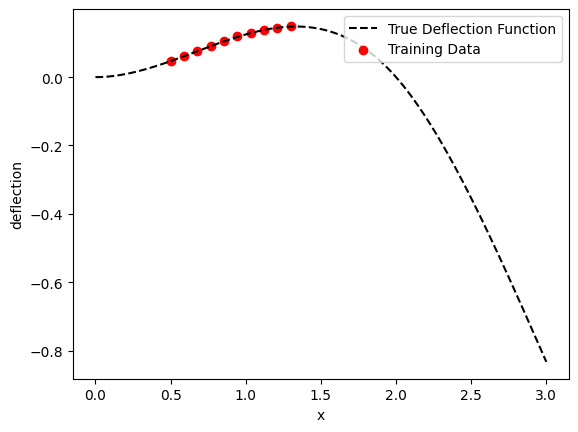

In [6]:
def deflection(x):
    # Young's modulus of steel 
    E = 200e9
    # length of the beam 
    L = 1
    # moment of inertia of the beam cross-section
    I = 1e-8
    # load 
    P = 2000
    if 0 <= x <= 2*L:
        return ((-P/(8*E*I))*x**3) + ((P*L)/(4*E*I)*x**2)
    else:
        return ((P/(6*E*I))*x**3) - (((3*P*L)/(2*E*I))*x**2) + (((7*P*L**2)/(2*E*I))*x) -((7*P*L**3)/(3*E*I))

def deflection_noise(x):
    return deflection(x) + np.random.normal(0, 0.001)

x_true = np.linspace(0, 3, 300)
y_true = np.array([deflection(i) for i in x_true])

# training data - 10 samples between 0.5L and 1.3L
x_train = np.linspace(0.5, 1.3, 10)
y_train = np.array([deflection_noise(i) for i in x_train])

# plot the data
plt.plot(x_true, y_true, label="True Deflection Function", color="black", linestyle="--")
plt.scatter(x_train, y_train, label="Training Data", color="red")
plt.xlabel("x")
plt.ylabel("deflection")
plt.legend(loc = 'upper right')
plt.show()

ds_train = torch.utils.data.TensorDataset(torch.tensor(x_train).float().view(-1, 1), torch.tensor(y_train).float().view(-1, 1))
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=10, shuffle=True)


In [154]:
@variational_estimator
class UniformPriorHeteroscedasticRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, 
                 uniform_low = -15.0, uniform_high = 15.0, 
                 posterior_mu_init = 0.0, posterior_rho_init = -7.0):
        super().__init__()
        # Layers for prediction
        
        self.blinear = nn.Sequential(
            BayesianLinear(input_dim, 2048, bias=True, 
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
            nn.GELU(),
            BayesianLinear(2048, 2048, bias=True, 
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
            nn.GELU(),
            BayesianLinear(2048, output_dim, bias=True,
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)
        )

        
    def forward(self, x):
        # Prediction path
        
        x = self.blinear(x)
        x_pred = x[:, 0].unsqueeze(1)
        x_log_noise = x[:, 1].unsqueeze(1)

        # resolve x_log_noise to be positive
        x_log_noise = torch.log1p(torch.exp(x_log_noise))
        return x_pred, x_log_noise


In [75]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [76]:
beam_regression = UniformPriorHeteroscedasticRegressor(1, 2).to(device)

def derivative_constraint_fn(*args, **kwargs):
    
	pred = beam_regression(x_derivative)[0]
	d_pred = (pred[1] - pred[0])/(2*0.05)
	return d_pred.squeeze()

def value_constraint_fn(*args, **kwargs):
    pred = beam_regression(x_value)[0]
    return pred.squeeze()

x_derivative = torch.tensor([[0.0], [0.05]]).float().to(device)
y_derivative = torch.tensor([0.0]).float().to(device)

x_value = torch.tensor([[0.0], [2.0]]).float().to(device)
y_value = torch.tensor([[0.0], [0.0]]).float().to(device)


value_constraint = mdmm.EqConstraint(value_constraint_fn, y_value.squeeze())
derivative_constraint = mdmm.EqConstraint(derivative_constraint_fn, y_derivative)
mdmm_module = mdmm.MDMM([value_constraint, derivative_constraint])
criterion = nn.GaussianNLLLoss()
opt_beam_regression = mdmm_module.make_optimizer(beam_regression.parameters(), lr=1e-3)

In [79]:
best_loss = 1e9

for epoch in range(20000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints, labels = datapoints.to(device), labels.to(device)
        _, loss_total, loss_data, loss_complexity = beam_regression.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/x_train.shape[0]
        )
        mdmm_return = mdmm_module(loss_total)
        opt_beam_regression.zero_grad()
        mdmm_return.value.backward()
        opt_beam_regression.step()
        # total_constraint_infeasibility = mdmm_return.infs[0].detach().clone().abs().sum() + mdmm_return.infs[1].detach().clone().abs().sum()
        if mdmm_return.value.item() < best_loss:
            best_model = beam_regression
            print('Best model saved at epoch', epoch)
        
        if i % 10 == 0:
            print('Epoch', epoch, 'Loss_total', mdmm_return.value.item(), 'Loss_data', loss_data.item(), 'Loss_complexity', loss_complexity.item(), 
                  'Value Infeasibility at left end', mdmm_return.infs[0][0].item(), 'Derivative Infeasibility at left end', mdmm_return.infs[1].item(), 
                  'Value inf at pin L = 2.0', mdmm_return.infs[0][1].item())
    if mdmm_return.infs[0][0].abs().item() < 1e-2 and mdmm_return.infs[0][1].abs().item() < 1e-1 and mdmm_return.infs[1].abs().item() < 1e-1 and loss_data.item() < -3.0:
        print('Constraints satisfied')
        best_model = beam_regression
        # exit the training loop
        break

    
            

Best model saved at epoch 0
Epoch 0 Loss_total 4614346.5 Loss_data -2.873420000076294 Loss_complexity 4614349.5 Value Infeasibility at left end -0.020956985652446747 Derivative Infeasibility at left end 0.002789124846458435 Value inf at pin L = 2.0 -0.043469883501529694
Best model saved at epoch 1
Epoch 1 Loss_total 4614601.0 Loss_data -3.1358344554901123 Loss_complexity 4614604.0 Value Infeasibility at left end 0.006731957197189331 Derivative Infeasibility at left end 0.010412931442260742 Value inf at pin L = 2.0 0.018644779920578003
Constraints satisfied


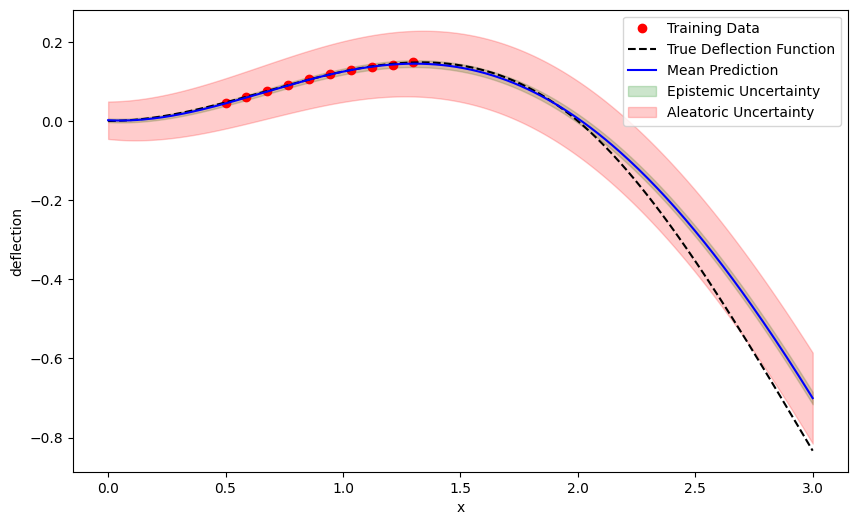

In [80]:
# plotting 
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, 'ro', label='Training Data')
plt.plot(x_true, y_true, label="True Deflection Function", color="black", linestyle="--")

x_plot = torch.linspace(0, 3, 300).view(-1, 1).to(device)

with torch.no_grad():
    preds = [best_model(x_plot)[0].cpu().detach().numpy() for _ in range(100)]
    preds = np.stack(preds)
    mean = np.mean(preds, axis=0)
    std = np.std(preds, axis=0)
    ale = best_model(x_plot)[1].cpu().detach().numpy()
    ale = ale**0.5
    plt.plot(x_plot.squeeze().cpu().numpy(), mean, label="Mean Prediction", color="blue")
    plt.fill_between(x_plot.squeeze().cpu().numpy(), mean.squeeze() - 2*std.squeeze(), mean.squeeze() + 2*std.squeeze(), color="green", alpha=0.2, label="Epistemic Uncertainty")
    plt.fill_between(x_plot.squeeze().cpu().numpy(), mean.squeeze() - 2*ale.squeeze(), mean.squeeze() + 2*ale.squeeze(), color="red", alpha=0.2, label="Aleatoric Uncertainty")
    plt.xlabel("x")
    plt.ylabel("deflection")
    plt.legend(loc = 'upper right')
    
    
plt.show()
    

In [155]:
x_train = np.linspace(0.5, 1.3, 10)
y_train = np.array([deflection_noise(i) for i in x_train])

x_train_additional = np.linspace(2.75, 3, 3)
y_train_additional = np.array([deflection_noise(i) for i in x_train_additional])

x_train = np.concatenate((x_train, x_train_additional))
y_train = np.concatenate((y_train, y_train_additional))

ds_train = torch.utils.data.TensorDataset(torch.tensor(x_train).float().view(-1, 1), torch.tensor(y_train).float().view(-1, 1))
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=10, shuffle=True)


In [177]:
beam_regression = UniformPriorHeteroscedasticRegressor(1, 2).to(device)

def derivative_constraint_fn(*args, **kwargs):
    
	pred = beam_regression(x_derivative)[0]
	d_pred = (pred[1] - pred[0])/(2*0.05)
	return d_pred.squeeze()

def value_constraint_fn(*args, **kwargs):
    pred = beam_regression(x_value)[0]
    return pred.squeeze()

x_derivative = torch.tensor([[0.0], [0.05]]).float().to(device)
y_derivative = torch.tensor([0.0]).float().to(device)

x_value = torch.tensor([[0.0], [2.0]]).float().to(device)
y_value = torch.tensor([[0.0], [0.0]]).float().to(device)


value_constraint = mdmm.EqConstraint(value_constraint_fn, y_value.squeeze())
derivative_constraint = mdmm.EqConstraint(derivative_constraint_fn, y_derivative)
mdmm_module = mdmm.MDMM([value_constraint, derivative_constraint])
criterion = nn.GaussianNLLLoss()
opt_beam_regression = mdmm_module.make_optimizer(beam_regression.parameters(), lr=1e-3)

In [184]:
best_loss = 1e9
data_loss_history = []
mse_risk = nn.MSELoss(reduction='sum')
for epoch in range(20000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints, labels = datapoints.to(device), labels.to(device)
        _, loss_total, loss_data, loss_complexity = beam_regression.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/x_train.shape[0]
        )
        data_loss_history.append(loss_data.item())
        mse_loss = mse_risk(beam_regression(datapoints)[0], labels).detach()
        mdmm_return = mdmm_module(loss_total)
        opt_beam_regression.zero_grad()
        mdmm_return.value.backward()
        opt_beam_regression.step()
        # total_constraint_infeasibility = mdmm_return.infs[0].detach().clone().abs().sum() + mdmm_return.infs[1].detach().clone().abs().sum()
        if i % 10 == 0:
            print('Epoch', epoch, 'Loss_total', mdmm_return.value.item(), 'Loss_data', mse_loss.item(), 'Loss_complexity', loss_complexity.item(), 
                  'Value Infeasibility at left end', mdmm_return.infs[0][0].item(), 'Derivative Infeasibility at left end', mdmm_return.infs[1].item(), 
                  'Value inf at pin L = 2.0', mdmm_return.infs[0][1].item())
    # if epoch % 25 == 0:
    #     # compute the variance of the data loss over the past 25 epochs
    #     data_loss_variance = np.var(data_loss_history[-25:])
    if mdmm_return.infs[0][0].abs().item() < 5e-3 and mdmm_return.infs[0][1].abs().item() < 5e-3 and mdmm_return.infs[1].abs().item() < 5e-3 \
    and mse_loss.item() < 1e-3:
        print('Constraints satisfied: Value Infeasibility at left end', mdmm_return.infs[0][0].item(), 'Derivative Infeasibility at left end', mdmm_return.infs[1].item(), 
              'Value inf at pin L = 2.0', mdmm_return.infs[0][1].item(), 'MSE Loss', mse_loss.item())
        best_model = beam_regression
        # exit the training loop
        break

    
            

Epoch 0 Loss_total 2898390.75 Loss_data 0.0008506110170856118 Loss_complexity 2898393.75 Value Infeasibility at left end -0.011023007333278656 Derivative Infeasibility at left end -0.00467345118522644 Value inf at pin L = 2.0 0.02080194652080536
Epoch 1 Loss_total 2898157.0 Loss_data 0.01033670175820589 Loss_complexity 2898160.0 Value Infeasibility at left end -0.013655990362167358 Derivative Infeasibility at left end -0.0033349543809890747 Value inf at pin L = 2.0 0.05083926022052765
Epoch 2 Loss_total 2898235.5 Loss_data 0.002384574618190527 Loss_complexity 2898238.5 Value Infeasibility at left end -0.059731826186180115 Derivative Infeasibility at left end 0.0066249072551727295 Value inf at pin L = 2.0 0.025318875908851624
Epoch 3 Loss_total 2898297.0 Loss_data 0.004781649447977543 Loss_complexity 2898300.0 Value Infeasibility at left end -0.05602738633751869 Derivative Infeasibility at left end 0.004382915794849396 Value inf at pin L = 2.0 0.015213318169116974
Epoch 4 Loss_total 289

In [179]:
unconstrained_model = UniformPriorHeteroscedasticRegressor(1, 2).to(device)
opt_unconstrained = optim.Adam(unconstrained_model.parameters(), lr=1e-4)
criterion = nn.GaussianNLLLoss()
best_loss = 1e9
for epoch in range(20000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints, labels = datapoints.to(device), labels.to(device)
        _, loss_total, loss_data, loss_complexity = unconstrained_model.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/x_train.shape[0]
        )
        mse_loss = mse_risk(unconstrained_model(datapoints)[0], labels).detach()
        opt_unconstrained.zero_grad()
        loss_total.backward()
        opt_unconstrained.step()
        if loss_total.item() < best_loss:
            best_loss = loss_total.item()
            best_model_unconstrained = unconstrained_model
            print('Best model saved at epoch', epoch)
        
        if i % 10 == 0:
            print('Epoch', epoch, 'Loss_total', loss_total.item(), 'Loss_data', loss_data.item(), 'Loss_complexity', loss_complexity.item())
    if mse_loss.item() < 1e-3:
        print('Constraints satisfied')
        best_model = unconstrained_model
        # exit the training loop
        break

Best model saved at epoch 0
Epoch 0 Loss_total 2905101.5 Loss_data 1.8726345300674438 Loss_complexity 2905099.75
Best model saved at epoch 1
Epoch 1 Loss_total 2905070.75 Loss_data 0.349020391702652 Loss_complexity 2905070.5
Epoch 2 Loss_total 2905263.25 Loss_data 0.6433538794517517 Loss_complexity 2905262.5
Best model saved at epoch 3
Epoch 3 Loss_total 2905051.0 Loss_data 0.6798011660575867 Loss_complexity 2905050.25
Epoch 4 Loss_total 2905186.0 Loss_data 0.3556841313838959 Loss_complexity 2905185.75
Best model saved at epoch 5
Epoch 5 Loss_total 2904941.5 Loss_data 0.21652507781982422 Loss_complexity 2904941.25
Epoch 6 Loss_total 2905173.0 Loss_data 0.29034140706062317 Loss_complexity 2905172.75
Epoch 7 Loss_total 2905054.0 Loss_data -0.24139682948589325 Loss_complexity 2905054.25
Epoch 8 Loss_total 2905290.0 Loss_data -0.5883541703224182 Loss_complexity 2905290.5
Epoch 9 Loss_total 2904989.5 Loss_data -0.8045133948326111 Loss_complexity 2904990.25
Epoch 10 Loss_total 2904945.25 Los

KeyboardInterrupt: 

In [1]:
# plotting 
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, 'ro', label='Training Data')
plt.plot(x_true, y_true, label="True Deflection Function", color="black", linestyle="--")

x_plot = torch.linspace(0, 3, 300).view(-1, 1).to(device)

with torch.no_grad():
    preds = [best_model(x_plot)[0].cpu().detach().numpy() for _ in range(100)]
    preds = np.stack(preds)
    mean = np.mean(preds, axis=0)
    std = np.std(preds, axis=0)
    ale = best_model(x_plot)[1].cpu().detach().numpy()
    ale = ale**0.5
    
    # preds_unconstrained = [best_model_unconstrained(x_plot)[0].cpu().detach().numpy() for _ in range(100)]
    # preds_unconstrained = np.stack(preds_unconstrained)
    # mean_unconstrained = np.mean(preds_unconstrained, axis=0)
    # std_unconstrained = np.std(preds_unconstrained, axis=0)
    # ale_unconstrained = unconstrained_model(x_plot)[1].cpu().detach().numpy()
    # ale_unconstrained = ale_unconstrained**0.5
    
    # plt.plot(x_plot.squeeze().cpu().numpy(), mean_unconstrained, label="Mean Prediction - BNN", color="blue")
    plt.plot(x_plot.squeeze().cpu().numpy(), mean, label="Mean Prediction - BENN", color="red")
    # plt.fill_between(x_plot.squeeze().cpu().numpy(), mean_unconstrained.squeeze() - 2*std_unconstrained.squeeze(), mean_unconstrained.squeeze() + 2*std_unconstrained.squeeze(), color="green", alpha=0.2, label="Epistemic Uncertainty - BNN")
    plt.fill_between(x_plot.squeeze().cpu().numpy(), mean.squeeze() - 2*std.squeeze(), mean.squeeze() + 2*std.squeeze(), color="green", alpha=0.2, label="Epistemic Uncertainty")
    # plt.fill_between(x_plot.squeeze().cpu().numpy(), mean.squeeze() - 2*ale.squeeze(), mean.squeeze() + 2*ale.squeeze(), color="red", alpha=0.2, label="Aleatoric Uncertainty")
    plt.xlabel("x")
    plt.ylabel("deflection")
    plt.legend(loc = 'upper right')
    
    
plt.show()
    

NameError: name 'plt' is not defined